# Comparing different structures

Sometimes you want to compare the contact map of two things that have different topologies. This example notebook will run through a couple of common occurences and the options for those. 

## Comparing mutated protein.

In order to look at the contact map difference between for example a WT and a mutated protein there are a couple options. We will use the KRAS pdb's [4OBE](https://www.rcsb.org/structure/4obe) (WT) and [5V9O](https://www.rcsb.org/structure/5V9O) (G12C).

In [1]:
import mdtraj as md
from contact_map import ContactFrequency 

In [2]:
WT_full = md.load("data/4obe.pdb") # Load the wildtype structure
# This pdb contains 2 protein chains and we only want one (and not without GDP 168)
WT_chain1 = WT_full.atom_slice(WT_full.topology.select("resid 0 to 167")) 


G12C_full = md.load("data/5v9o.pdb") # Load the mutated structure
# Cut this one down to just the protein
G12C_protein = G12C_full.atom_slice(G12C_full.topology.select("resid 0 to 167"))

wt_map = ContactFrequency(WT_chain1)
g12c_map = ContactFrequency(G12C_protein)

print(wt_map.topology.residue(11)) 
print(g12c_map.topology.residue(11))

GLY12
CYS12


 If we now try to subtract the two, this will fail because we can't overlap the atom contact maps

In [3]:
#diff = wt_map - g12c_map # This will fail, because the atom indices don't make sense

But, we can still look at the residues by using `AtomMismatchedContactDifference`

[([GLY/CYS12, LYS16], 0.0)]


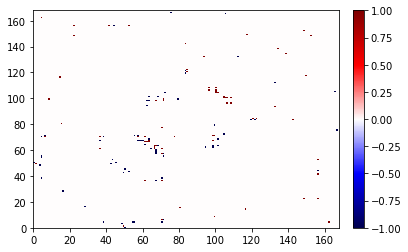

In [4]:
from contact_map import AtomMismatchedContactDifference

diff = AtomMismatchedContactDifference(wt_map, g12c_map)

# Grab residue 12
res = diff.topology.residue(11)

# Print the contact differences between WT and G12C (this will print GLY/CYS12 as residue name)
print(diff.residue_contacts.most_common(res))
diff.residue_contacts.plot();

# Looking at a truncated protein

Another option is to look at the difference between a truncated protein and the full protein. Here we will fake truncating the protein at residue 150.

In [5]:
full = WT_full # Start with the full trajectory

# Slice another trajectory down to 150 residues
truncated = WT_full.atom_slice(WT_full.topology.select("resid 0 to 150")) 

map_full = ContactFrequency(full)
map_truncated = ContactFrequency(truncated)


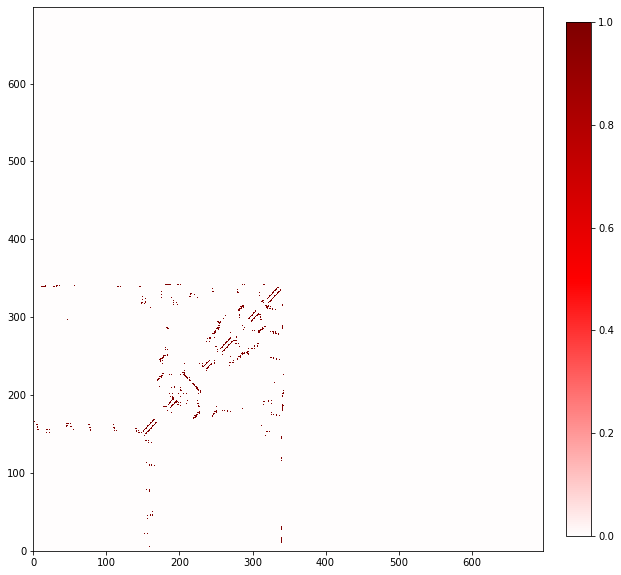

In [6]:
# Because we know that the topology for the full map is also correct for the truncated one we will override it.
from contact_map import OverrideTopologyContactDifference
# diff = map_full - map_truncated # This will fail
diff = OverrideTopologyContactDifference(map_full, map_truncated, topology=map_full.topology)
diff.residue_contacts.plot(figsize=(10,10));

# Looking at difference when the residue information is missing

Sometimes it can happen that the residue information is missing or does not make sense. This is more common for DFT-md simulations than protein simulations, but we will break one of the topologies here to illustrate this behavior and how to handle it

In [7]:
full = WT_chain1

# Make load again to make a copy and slice it down to the same number of atoms
broken = md.load("data/4obe.pdb").atom_slice(range(full.topology.n_atoms))
# Here we break the residues, making all atoms be a part of one big residue.
res = broken.topology.residue(1)
for i in range(broken.topology.n_atoms):
    broken.topology.atom(i).residue = res
    
map_full = ContactFrequency(full)
map_broken = ContactFrequency(broken)

/home/sander/github_files/contact_map/contact_map/contact_count.py:175: RuntimeWarning: The number of pixels in the figure is insufficient to show all the contacts.
 Please save this as a vector image (such as a PDF) to view the correct result.
 Another option is to increase the 'dpi' (currently: 72.0), or the 'figsize' (currently: (6.0, 4.0)).
 Recommended minimum amount of pixels = (2641, 2641) (width, height).
  warnings.warn(msg, RuntimeWarning)


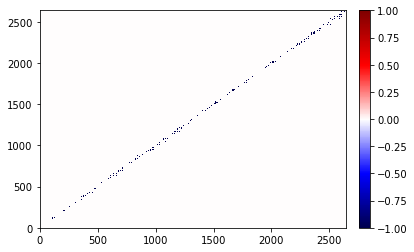

In [8]:
# Here the atoms are correct, but the residues does not make sense so we use ResidueMismatchedContactDifference.
# This can also be solved by using OverrideTopologyContactDifference
from contact_map import ResidueMismatchedContactDifference
# diff = map_full - map_broken
diff = ResidueMismatchedContactDifference(map_full, map_broken)
diff.atom_contacts.plot();